In [6]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from datasets import load_dataset
from sklearn.metrics import auc, accuracy_score, confusion_matrix, precision_recall_fscore_support, roc_curve
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
from typing import TypedDict

In [7]:
dataset = load_dataset("ag_news")

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [8]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

/Library/Python/3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
class DatasetItem(TypedDict):
    text: str
    label: str


def preprocess_data(dataset_item: DatasetItem) -> dict[str, torch.Tensor]:
    return tokenizer(dataset_item["text"], truncation=True, padding="max_length", return_tensors="pt")

In [10]:
train_dataset = dataset["train"].select(range(1200)).map(preprocess_data, batched=True)
test_dataset = dataset["test"].select(range(800)).map(preprocess_data, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [11]:
train_dataset.to_pandas()

,text,label,input_ids,token_type_ids,attention_mask
0,Wall St. Bears Claw Back Into the Black (Reute...,2,"[101, 2813, 2358, 1012, 6468, 15020, 2067, 204...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,"[101, 18431, 2571, 3504, 2646, 3293, 13395, 10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,"[101, 3514, 1998, 4610, 6112, 15768, 1005, 176...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,"[101, 5712, 9190, 2015, 3514, 14338, 2013, 236...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"Oil prices soar to all-time record, posing new...",2,"[101, 3514, 7597, 2061, 2906, 2000, 2035, 1011...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...
1195,Airline Looks to Delay Its Pension Payments In...,2,"[101, 8582, 3504, 2000, 8536, 2049, 11550, 105...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1196,McDonald's Goes for Gold For a four-year inves...,2,"[101, 9383, 1005, 1055, 3632, 2005, 2751, 2005...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1197,Auction for Shares In Google's IPO May End Tod...,3,"[101, 10470, 2005, 6661, 1999, 8224, 1005, 105...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1198,"Four Firms Buy Intelsat Intelsat Ltd., the pio...",3,"[101, 2176, 9786, 4965, 13420, 16846, 13420, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [12]:
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

/Library/Python/3.9/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        inputs = {key: batch[key].to(device) for key in batch}
        labels = inputs.pop("label")
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {average_loss}")

Epoch 1: 100%|██████████| 150/150 [12:03<00:00,  4.82s/it]


Epoch 1, Average Loss: 0.713780286560456


Epoch 2: 100%|██████████| 150/150 [25:18<00:00, 10.12s/it] 


Epoch 2, Average Loss: 0.32772616946448885


Epoch 3: 100%|██████████| 150/150 [1:02:17<00:00, 24.92s/it] 

Epoch 3, Average Loss: 0.22009184943512083


In [14]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        inputs = {key: batch[key].to(device) for key in batch}
        labels = inputs.pop("label")
        outputs = model(**inputs, labels=labels)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)
        correct += (predicted_labels == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total

print("")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Evaluating: 100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Test Accuracy: 84.88%


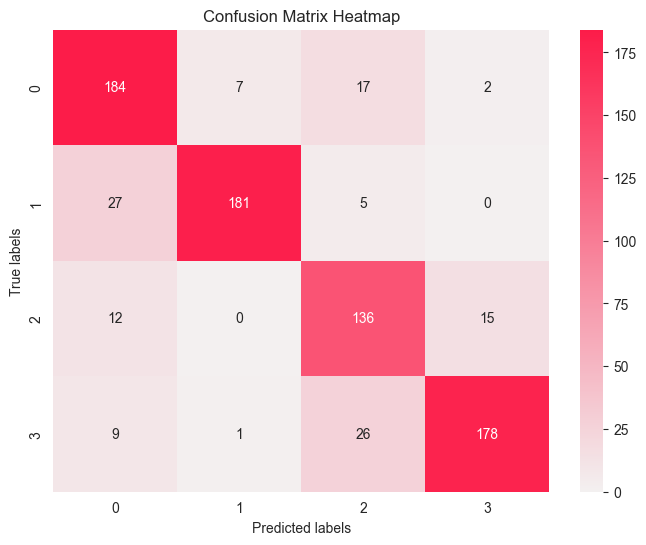

In [16]:
all_predictions: list[int] = []
all_labels: list[int] = []
all_probabilities: list[float] = []

with torch.no_grad():
    for batch in test_loader:
        inputs = {key: batch[key].to(device) for key in batch}
        labels = inputs.pop("label")
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)
        probabilities = F.softmax(logits, dim=1)

        all_predictions.extend(predicted_labels.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())
        

conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap=sns.light_palette("#fc1c49", as_cmap=True))
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix Heatmap")
plt.show()

/var/folders/r4/w6gk0qbd6bd_sf7xj6nwdnxc0000gn/T/ipykernel_83956/1190004819.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Metrics", y="Values", data=metrics_data, palette=["#fc1c49", "#00a67d", "#ffa71b", "#6f42c1"])


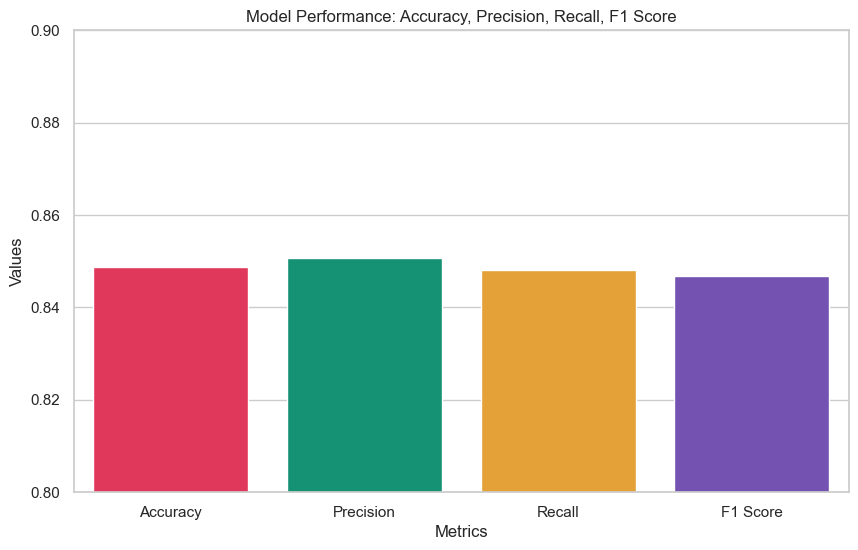

In [17]:
accuracy = accuracy_score(all_labels, all_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average="macro")

metrics_data = {
    "Metrics": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Values": [accuracy, precision, recall, f1]
}

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Metrics", y="Values", data=metrics_data, palette=["#fc1c49", "#00a67d", "#ffa71b", "#6f42c1"])
ax.set_ylim(0.8, 0.9)
plt.title("Model Performance: Accuracy, Precision, Recall, F1 Score")
plt.show()

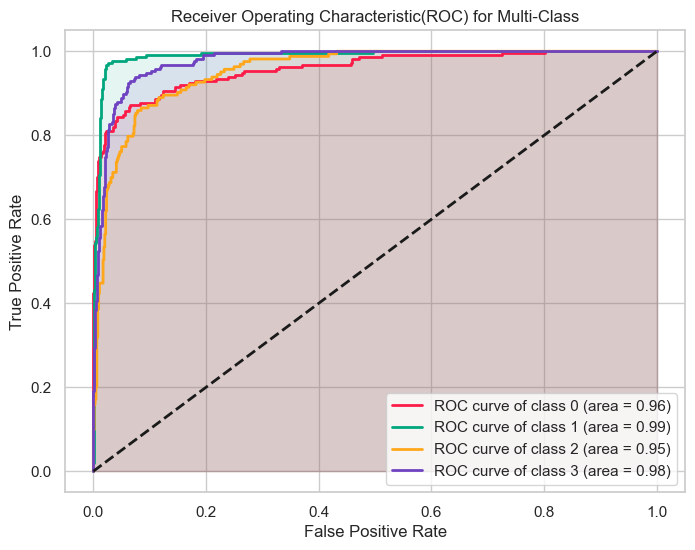

In [18]:
binary_labels = label_binarize(all_labels, classes=[0, 1, 2, 3])
all_probabilities = np.array(all_probabilities)

n_classes = binary_labels.shape[1]
fpr: dict[int, float] = {}
tpr: dict[int, float] = {}
roc_auc: dict[int, float] = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binary_labels[:, i], all_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))

colors = ["#fc1c49", "#00a67d", "#ffa71b", "#6f42c1"]
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve of class {i} (area = {roc_auc[i]:.2f})")
    plt.fill_between(fpr[i], tpr[i], color=color, alpha=0.1)

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic(ROC) for Multi-Class")
plt.legend(loc="lower right")
plt.show()